## Week 11
---
### Use the Taxi v2 environment:
https://www.gymlibrary.dev/environments/toy_text/taxi/

#### Learn the policy using the following algorithms (Let parameters α = 0.4, γ=  0.9, Ɛ= 0.9):
- 1. SARSA
- 2. Expected SARSA
#### Plot the episode vs. reward graph, compare, and comment on the performance of the three algorithms for 2000 episodes.
---

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import gym
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [2]:
#create the taxi env
env = gym.make('Taxi-v3')

#### using this for finding the policy value updation for the expected sarsa
- greedy action -> the one with the highest q value(which greedly we can choose)

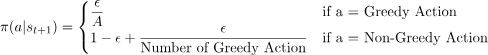

### Updation formulas

##### Sarsa

##### Expected Sarsa

In [17]:
class Agent:
    def __init__(self,algorithm='sarsa',alpha=0.4,gamma=0.9,epsilon=0.9,nA=6):
        """ Initialize agent.
        Params
        ======
        - algorithm: 'sarsa' or 'expected_sarsa'
        - alpha: learning rate, default = 0.4(for updates)
        - gamma: discount factor, default = 0.9(for rewards)
        - epsilon: exploration rate,default = 0.9(for epsilon greedy)
        - nA: number of actions,defaut = 6 for taxi env
        """
        self.algorithm = algorithm
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.num_of_actions = nA
        #for each state action pair we need i.e basically Q(s,a)
        self.Q = defaultdict(lambda: np.zeros(self.num_of_actions))
    
    def select_action(self, state):
        """Select action using epsilon-greedy policy
           given the state we find the action to chose among all the possible
           actions for the given state using epsilon-greedy
        """
        if np.random.random() < self.epsilon:
            #explore(return a random action index)
            return np.random.choice(self.num_of_actions)  # Randomly select an action from 0 to nA-1

        else:
            #exploit(take the max value of Q(s,a) for the state passed)
            return np.argmax(self.Q[state])
    
    def get_policy(self,next_state_q_values):
        """
        used only for expected sarsa
        take the next state q values i.e all Q(s,a) for the next state
        then we return the policy value using the equation of above  
        """
        policy_for_state = np.ones(self.num_of_actions) * self.epsilon / self.num_of_actions
        greedy_action = np.argmax(next_state_q_values)#get the greedy action and update policy for it
        
        policy_for_state[greedy_action] = 1 - self.epsilon + (self.epsilon / self.num_of_actions)
        
        return policy_for_state
    
    def update(self,state,action,reward,next_state=None,next_action=None,done=False):
        """ Update Q-values based on the algorithm
            
            Update the action value function using the Expected SARSA update.
            Q(S, A) = Q(S, A) + alpha(reward + (pi * Q(S_, A_) - Q(S, A))
            
            Update the action value function using the SARSA update.
            Q(S, A) = Q(S, A) + alpha(reward + (gamma * Q(S_, A_) - Q(S, A))
        """
#         action = int(action)
        current = self.Q[state][action]#get the current state action value fun
        
        if done:
            #then the value is reward i.e last terminal
            target = reward
        else:
            if self.algorithm=='sarsa':
                #if algo is sarsa then update using its formula
                target = reward + self.gamma * self.Q[next_state][next_action]
            elif self.algorithm== 'expected_sarsa':
                #update using the formula
                #get the policy for the next state
                policy_for_state = self.get_policy(self.Q[next_state])
                #when updating we need to sum over the policy(formula it is)
                target = reward + self.gamma * np.sum(policy_for_state * self.Q[next_state])
                
            else:
                raise ValueError("Not known algorithm passed")
        
        #updating the Q-value
        self.Q[state][action] = current + self.alpha * (target - current)

In [18]:
def run_experiment(algorithm, num_episodes=2000):
    """Run experiment with specified algorithm"""
    agent = Agent(algorithm=algorithm, alpha=0.4, gamma=0.9, epsilon=0.9)
    rewards = []
    avg_rewards = []
    
    for episode in tqdm(range(num_episodes), desc=f"{algorithm.upper()}"):
        state = env.reset()
        if isinstance(state, tuple):  # Handle newer Gym versions
            state = state[0]
        action = agent.select_action(state)
        total_reward = 0
        done = False
        
        while not done:
            step_result = env.step(action)
            if len(step_result) == 4:  # Older Gym versions
                next_state, reward, done, _ = step_result
            else:  # Newer Gym versions (v0.26+)
                next_state, reward, done, truncated, _ = step_result
                done = done or truncated
            
            total_reward += reward
            
            if not done:
                #so normal update
                next_action = agent.select_action(next_state)
                agent.update(state, action, reward, next_state, next_action, done)
                action = next_action
            else:
                #then terminal so as done pass
                agent.update(state, action, reward, done=done)
                
            state = next_state
        
        rewards.append(total_reward)
        
        # Calculate running average
        if episode >= 100:
            avg_rewards.append(np.mean(rewards[-100:]))
        else:
            avg_rewards.append(np.mean(rewards))
    
    return rewards, avg_rewards



EXPECTED_SARSA: 100%|██████████| 2000/2000 [00:07<00:00, 262.83it/s]


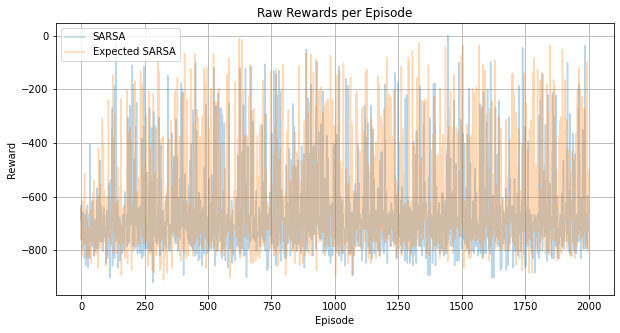

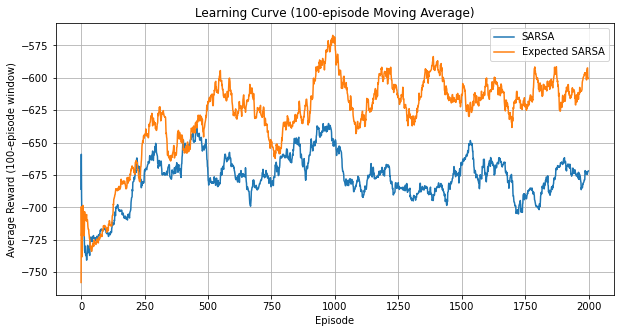

SARSA - Final Average Reward (last 100 episodes): -671.89
Expected SARSA - Final Average Reward (last 100 episodes): -600.58


In [19]:
# Run experiments
num_episodes = 2000
sarsa_rewards, sarsa_avg = run_experiment('sarsa', num_episodes)
expected_sarsa_rewards, expected_sarsa_avg = run_experiment('expected_sarsa', num_episodes)

# Plot raw rewards separately
plt.figure(figsize=(10, 5))
plt.plot(sarsa_rewards, label='SARSA', alpha=0.3)
plt.plot(expected_sarsa_rewards, label='Expected SARSA', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Raw Rewards per Episode')
plt.legend()
plt.grid(True)
plt.show()

# Plot moving averages separately
plt.figure(figsize=(10, 5))
plt.plot(sarsa_avg, label='SARSA')
plt.plot(expected_sarsa_avg, label='Expected SARSA')
plt.xlabel('Episode')
plt.ylabel('Average Reward (100-episode window)')
plt.title('Learning Curve (100-episode Moving Average)')
plt.legend()
plt.grid(True)
plt.show()

# Print final performance
print(f"SARSA - Final Average Reward (last 100 episodes): {np.mean(sarsa_rewards[-100:]):.2f}")
print(f"Expected SARSA - Final Average Reward (last 100 episodes): {np.mean(expected_sarsa_rewards[-100:]):.2f}")

# **Comparison of SARSA vs. Expected SARSA (2000 Episodes)**  

### **Final Performance (Last 100 Episodes)**  
- **SARSA**: `-671.89` average reward.  
- **Expected SARSA**: `-600.58` average reward.  
- **Expected SARSA** clearly outperforms SARSA in the final stages, with a **~10% better average reward**.  

---

### **Expected SARSA's Strengths**  
 **Lower variance** in rewards (fewer extreme negative spikes).  
 **Faster convergence** to better policies (higher average reward in later episodes).  
 **Reduced bias** by considering the *expected value* of the next state-action pair, leading to **more stable updates**.  

---

### **SARSA's Limitations**  
 **Higher variance** in rewards (e.g., `-929` in episode 116 for Expected SARSA vs. `-893` in episode 461 for SARSA).  
 **Slower convergence**, likely due to reliance on **sampled next actions**, introducing more noise.  

---

### **Algorithm Comparison**  
| **Metric**            | **SARSA** | **Expected SARSA** |  
|-----------------------|----------|-------------------|  
| **Final Performance** | -671.89  | -600.58       |  
| **Variance**          | High     | Low           |  
| **Convergence Speed** | Slow     | Faster        |  
| **Stability**         | Noisy    | More Stable   |  

- **Expected SARSA** is **theoretically more sound** because it reduces variance by using the *expected value* of the next state-action pair.  
- **SARSA**, while simpler, suffers from **higher variance** due to its dependence on sampled actions.  

---

### **Conclusion**  
In this case-> **2000 episodes**:  

🔹 **Expected SARSA is the better-performing algorithm**, achieving **higher average rewards** and **more stable learning** compared to SARSA.  

References:

- https://github.com/crazyleg/gym-taxi-v2-v3-solution
- https://www.geeksforgeeks.org/reinforcement-learning-in-python-implementing-sarsa-agent-in-taxi-environment/ (Uses epsilon decay)
- https://www.geeksforgeeks.org/expected-sarsa-in-reinforcement-learning/

🔹 If **computational resources allow**, use **Expected SARSA** for better policy quality.  
🔹 If **simplicity is a priority**, SARSA can still be used but may require **more tuning or episodes** to match Expected SARSA's performance.  

### Thank You